Data assimilation viewer

In [94]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import numpy as np
import interact_model as im

import jax_cfd.base as cfd

In [109]:
data_assim_arrays = jnp.load('assim_ex.npy')
data_assim_arrays.shape

(128, 128, 2, 3)

In [110]:
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 128
Ny = 128
Re = 100.

vel_assim = True # set false if fit on vort

In [111]:
if vel_assim == True:
  vel_true = data_assim_arrays[..., 0]
  vel_interp = data_assim_arrays[..., 1]
  vel_pred = data_assim_arrays[..., 2]
  vort_true = im.compute_vort_traj(vel_true[jnp.newaxis, ...], Lx / Nx, Ly / Ny)[0, ..., 0]
  vort_interp = im.compute_vort_traj(vel_interp[jnp.newaxis, ...], Lx / Nx, Ly / Ny)[0, ..., 0]
  vort_pred = im.compute_vort_traj(vel_pred[jnp.newaxis, ...], Lx / Nx, Ly / Ny)[0, ..., 0]
else:
  vort_true = data_assim_arrays[..., 0]
  vort_interp = data_assim_arrays[..., 1]
  vort_pred = data_assim_arrays[..., 2]

Take care -- if loading in vel the vort_interp will look smooth since we did bicubic smoothing on the IC

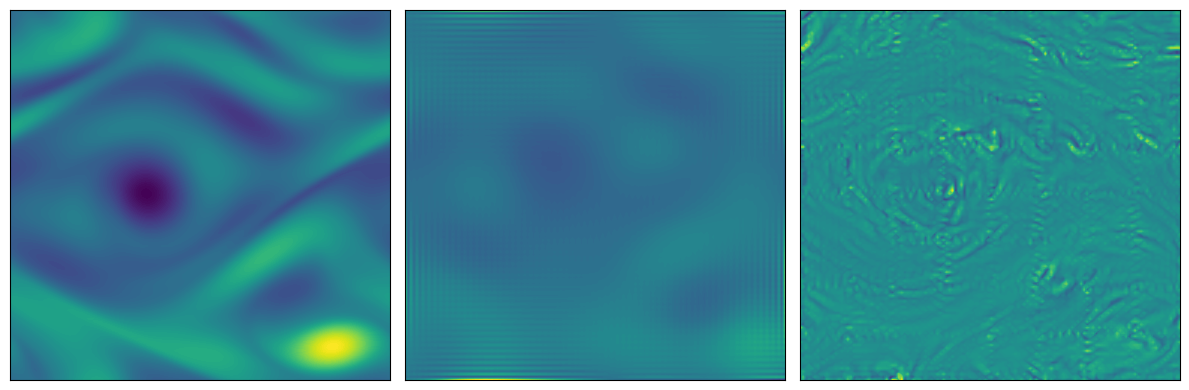

In [112]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True
})

fig = plt.figure(figsize=(12, 4))
ax_num = 1
ax = fig.add_subplot(1, 3, 1)
ax.contourf(vort_true.T, 101)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 2)
ax.contourf(vort_interp.T, 101)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 3)
ax.contourf(vort_pred.T, 101)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

Now plot error vs true time evolution and the error in the standard "bicubic" interpolation

In [113]:
import time_stepping as ts
from functools import partial

# assimilation parameters
T_unroll = 10. 
T_da = 1.5 # time over which assimilation was performed
M_substep = 8 # when to compare

# (0) build grid, stable timestep etc
grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1. / Re, grid) / 2.

# (2) create forward trajectory and downsample
dt_stable = np.round(dt_stable, 3)
t_substep = M_substep * dt_stable
trajectory_fn = ts.generate_trajectory_fn(Re, T_unroll + 1e-2, dt_stable, grid, t_substep=t_substep)

def real_to_real_traj_fn(vort_phys, trajectory_fn):
  vort_rft = jnp.fft.rfftn(vort_phys, axes=(0,1))
  _, vort_traj_rft = trajectory_fn(vort_rft)
  return jnp.fft.irfftn(vort_traj_rft, axes=(1,2))

real_traj_fn = partial(real_to_real_traj_fn, trajectory_fn=trajectory_fn)

In [114]:
true_trajectory = real_traj_fn(vort_true)
inte_trajectory = real_traj_fn(vort_interp)
pred_trajectory = real_traj_fn(vort_pred)

if vel_assim == True:
  true_trajectory = im.compute_vel_traj(true_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
  inte_trajectory = im.compute_vel_traj(inte_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
  pred_trajectory = im.compute_vel_traj(pred_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)

In [115]:
t_grid = np.linspace(M_substep * dt_stable, 
                     len(true_trajectory) * M_substep * dt_stable, 
                     len(true_trajectory))

error_pred = []
error_inte = []

for n, _ in enumerate(t_grid):
  if vel_assim == True:
    e_p = jnp.linalg.norm((true_trajectory[n] - pred_trajectory[n]).flatten()) / jnp.linalg.norm(vel_true.flatten())
    e_i = jnp.linalg.norm((true_trajectory[n] - inte_trajectory[n]).flatten()) / jnp.linalg.norm(vel_true.flatten())
  else:
    e_p = jnp.linalg.norm((true_trajectory[n] - pred_trajectory[n]).flatten()) / jnp.linalg.norm(vort_true.flatten())
    e_i = jnp.linalg.norm((true_trajectory[n] - inte_trajectory[n]).flatten()) / jnp.linalg.norm(vort_true.flatten())
  error_pred.append(e_p)
  error_inte.append(e_i)

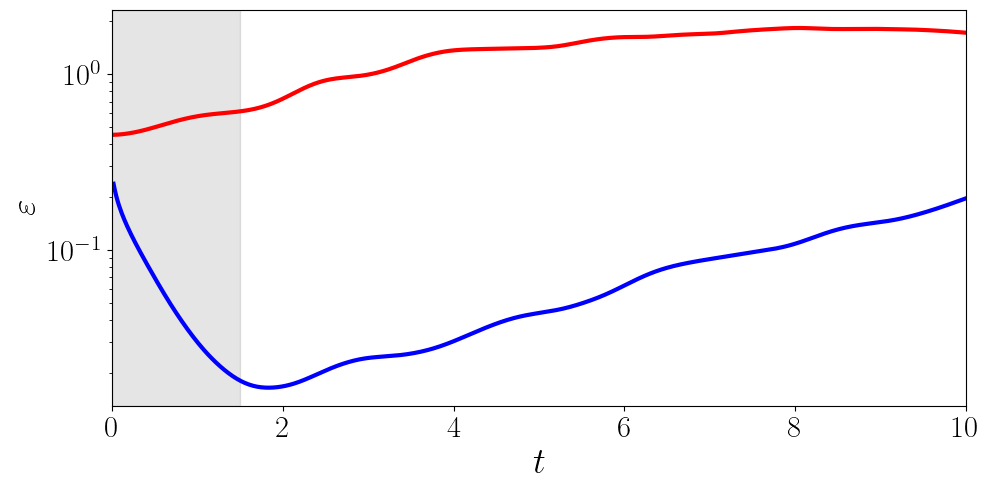

In [116]:
fig = plt.figure(figsize=(10, 5)) 
ax1 = fig.add_subplot(1, 1, 1)
ax1.tick_params(labelsize=22)

ax1.axvspan(0, T_da, color='k', alpha=0.1)

ax1.plot(t_grid, error_pred, c='b', linewidth=3)
ax1.plot(t_grid, error_inte, c='r', linewidth=3)
  
ax1.set_xlabel(r'$t$', fontsize=26)
ax1.set_ylabel(r'$\varepsilon$', fontsize=26)

ax1.set_xlim(0, t_grid[-1])
ax1.set_yscale('log')

fig.tight_layout()

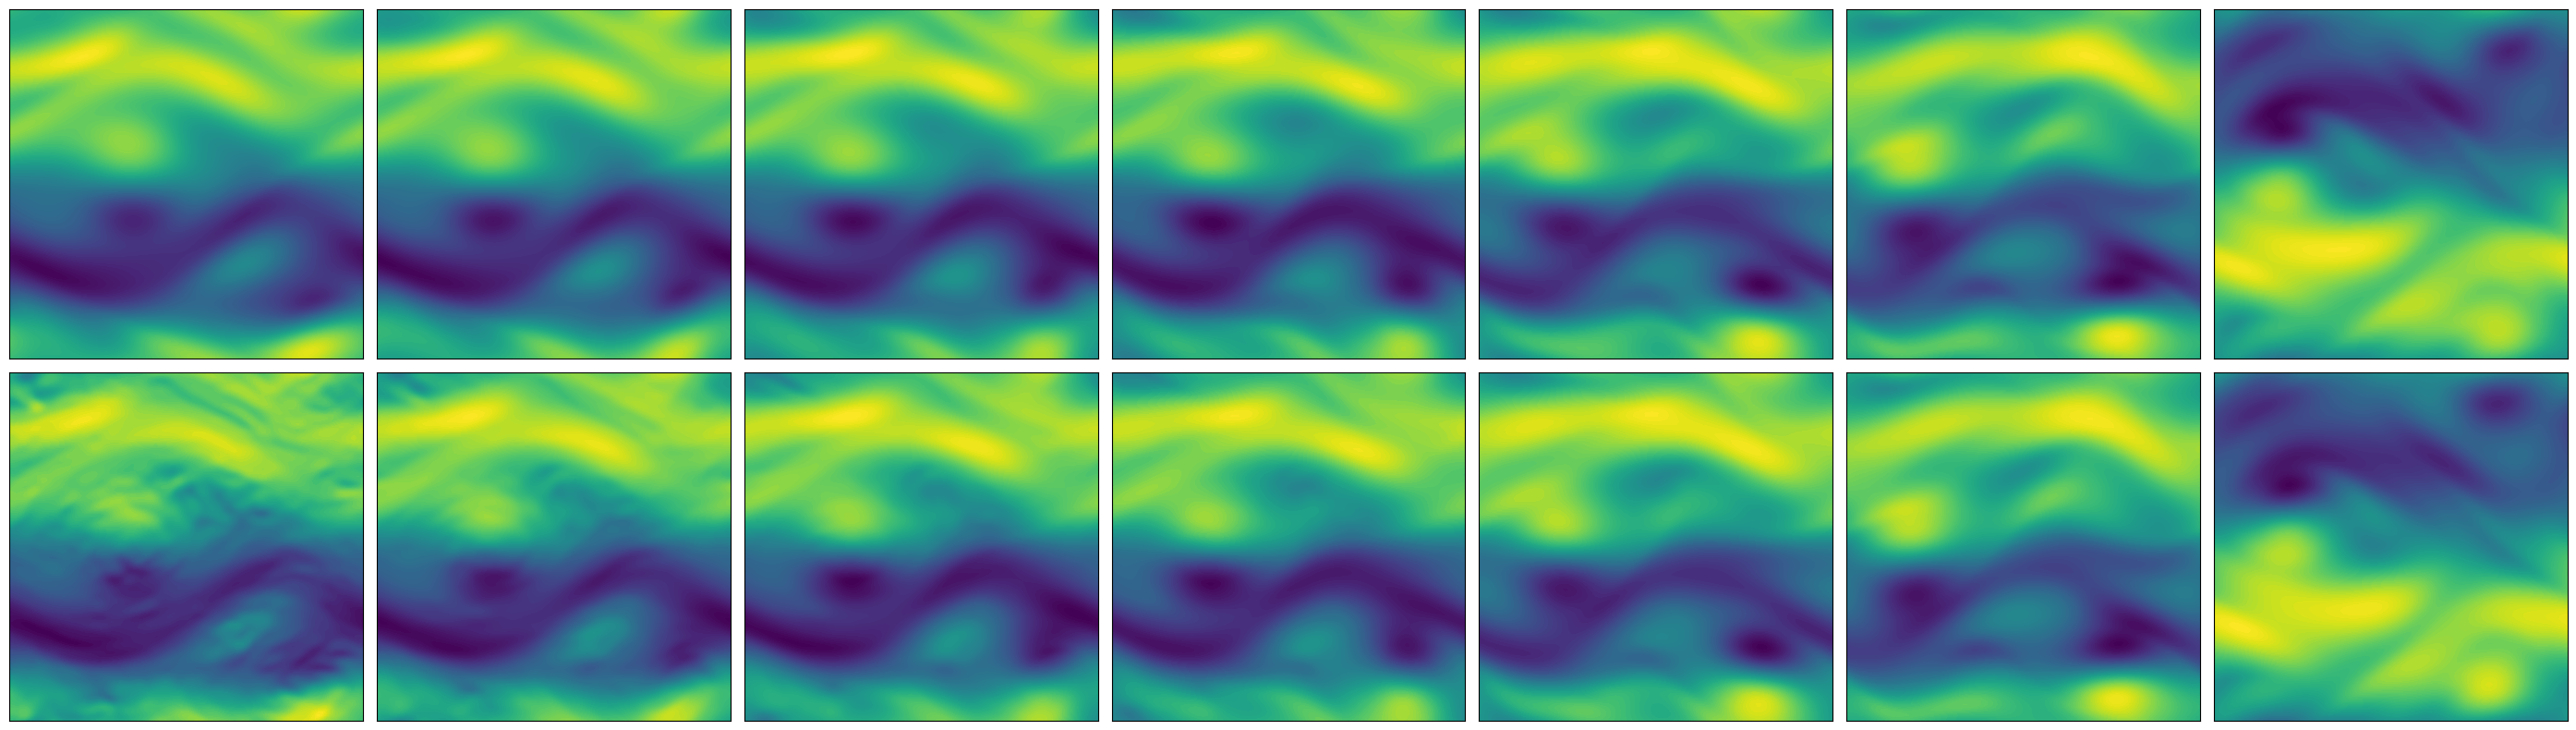

In [117]:
T_extract = [0.25, 0.5, 0.75, 1., 1.5, 2., 10.]
N_extract = [int(t_e / (M_substep * dt_stable)) for t_e in T_extract]

n_plot = len(N_extract)

fig = plt.figure(figsize=(4 * n_plot, 8))
ax_num = 1

v_comp = 0 # if vel assim, which component to plot? if set to "2" -> plot vorticity

# compute vort (again ... ) if plotting
if v_comp > 1:
  vort_true_traj = im.compute_vort_traj(true_trajectory, Lx / Nx, Ly / Ny)[..., 0]
  vort_pred_traj = im.compute_vort_traj(pred_trajectory, Lx / Nx, Ly / Ny)[..., 0]

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for n in N_extract:
  if vel_assim == True:
    if v_comp < 2:
      v_true = true_trajectory[n, ..., v_comp]
      v_pred = pred_trajectory[n, ..., v_comp]
    else:
      v_true = vort_true_traj[n]
      v_pred = vort_pred_traj[n]
  else:
    v_true = true_trajectory[n]
    v_pred = pred_trajectory[n]

  ax = fig.add_subplot(2, n_plot, ax_num)
  ax.contourf(v_true.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_plot, ax_num + n_plot)
  ax.contourf(v_pred.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])


  ax_num += 1
fig.tight_layout()

In [ ]:
file_number = 100
traj_test = jnp.load('/Users/jpage2/code/jax-cfd-data-gen/Re100test/vort_traj.' 
                     + str(file_number).zfill(4) 
                     + '.npy')

In [ ]:
N_extract = [0, 1, 2, 3, 4]
n_plot = len(N_extract)

fig = plt.figure(figsize=(4 * n_plot, 4))
ax_num = 1

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for n in N_extract:
  v_true = traj_test[n]

  ax = fig.add_subplot(1, n_plot, ax_num)
  ax.contourf(v_true.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])


  ax_num += 1
fig.tight_layout()

In [ ]:
vort_zero = 0 * vort_true
vort_zero_traj = real_traj_fn(vort_zero)

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax_num = 1
ax = fig.add_subplot(1, 3, 1)
c = ax.contourf(vort_zero_traj[-1].T * 4, 101)
cbar = plt.colorbar(c)

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()

In [ ]:
jnp.max(vort_zero_traj[-1] * 4)